## Problem Set 1

In [169]:
import os

import numpy as np
import pandas as pd

import scipy.stats as sps
import scipy.special
import scipy.optimize

import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
# helper functions
def dict_to_table(d: dict, fname: str | os.PathLike, 
                  fpath: str | os.PathLike="../../data/05_reporting/problem_set_1"
) -> None:
    """Write LaTeX table from dictionary using Pandas.

    Args:
        d (dict): Column names will be keys.
        fname (str | os.PathLike): File name.
        fpath (str | os.PathLike, optional): 
            Defaults to "../../data/05_reporting/problem_set_1".
    """

    fpath = os.path.join(fpath, fname)
    tex = (pd.DataFrame(d)
           .to_latex(float_format="%.3f",
                     sparsify=True,
                     index=False)
    )
    with open(fpath, "w") as file:
        file.write(tex)
    

## Question 5

In [171]:
X = np.array([4, 1, 1, 3, 2, 6, 2, 3, 2, 1, 1, 2, 1, 2, 0, 4, 4, 2])
n_subs = len(X)
n_subs

18

In [172]:
class n_binom():
    """Initialize hand-written negative binomial distribution.

        Args:
            r (int): r
            p (float): p
        """
    def __init__(self, r: int, p: float):
        self.r=r
        self.p=p
    
    def pmf(self, k:float):
        """Probability mass function."""

        ft_top = k+self.r-1
        first_term = self._factorial(top=ft_top, bottom=k)
        second_term = (1-self.p)**k
        third_term = self.p**self.r

        return first_term * second_term * third_term

    def expect(self):
        """Expectation."""
        return (self.r * (1 - self.p)) / self.p
    
    def var(self):
        """Variance"""
        return (self.r * (1 - self.p)) / self.p**2
    
    def _factorial(self, top, bottom):
        """Helper function for evaluating `choose`."""
        top_fact = scipy.special.factorial(top)
        bottom_fact = scipy.special.factorial(bottom)
        tmb_fact = scipy.special.factorial(top - bottom)

        return top_fact / (bottom_fact * tmb_fact)

In [173]:
def all_equal(X, r=5, p=0.5):
    """Determine if equal within working precision."""

    r=5
    p=0.5

    nbinom_ajb = n_binom(r=r, p=p)
    sps_nbinom = sps.nbinom(n=r, p=p)

    pmf = np.allclose(nbinom_ajb.pmf(X), sps_nbinom.pmf(X))
    expect = np.allclose(nbinom_ajb.expect(), sps_nbinom.expect())
    var = np.allclose(nbinom_ajb.var(), sps_nbinom.var())

    return all([pmf, expect, var])

all_equal(X)

True

## 5.2 

In [174]:
class mpoxModel:
    """Define mpox transmission model."""
    def __init__(self, X: list, a: float, b: float, r: int=5):
        """_summary_

        Args:
            X (list): Data in list form. Integers expected.
            a (float): Passed to `scipy.stats.beta`.
            b (float): Passed to `scipy.stats.beta`.
            r (int, optional): Passed to `scipy.stats.nbinom`. Defaults to 5.
        """
        self.a = a
        self.b = b
        self.r = r
        self.X = X
        self.k = sum(X)
        self.n = len(X)

    def posterior(self) -> sps.rv_frozen:
        """Define posterior distribution.

        Returns:
            sps.rv_frozen: Beta distribution.
        """     
        a_term = self.a + np.sum(self.X)
        b_term = self.b + self.n
        return sps.beta(a_term, b_term)
    
    def posterior_mode(self, n_trials=10) -> float:
        """Find MAP numerically."""
        best_minimum = float('inf')
        for _ in range(n_trials):
            p0 = self.prior().rvs()
            results = scipy.optimize.minimize(lambda p: -self.posterior().pdf(p), p0)
            if results['fun'] < best_minimum:
                best_result = results
                best_minimum = results['fun']
        return best_result['x'][0]
    
    def summaries(self, interval=0.95):
        """Return table of posterior summaries."""
        post_interval = self.posterior().interval(interval)
        post_interval = f"{post_interval[0]:.3f}, {post_interval[1]:.3f}"

        res = {
            'Posterior Mean': self.posterior().mean(),
            'Posterior Mode': self.posterior_mode(),
            'Posterior Median': self.posterior().median(),
            f'Posterior Intervals ({interval})': [post_interval]
        }
        return res
        
    # for plotting
    def prior(self):
        """Define Beta prior."""
        return sps.beta(self.a, self.b)
    
    def likelihood(self, p):
        """Define negative binomial likelihood."""
        dist = sps.nbinom(n=self.r, p=p)
        return dist.pmf(self.X)


In [175]:
p_space = np.linspace(0, 1, 100)
a = 1
b = 1

model = mpoxModel(X, a, b)
summaries = model.summaries()
dict_to_table(summaries, "bnb_posterior_summary.tex")
summaries

{'Posterior Mean': np.float64(0.6885245901639344),
 'Posterior Mode': np.float64(0.6949152495218203),
 'Posterior Median': np.float64(0.6905970022292487),
 'Posterior Intervals (0.95)': ['0.568, 0.797']}

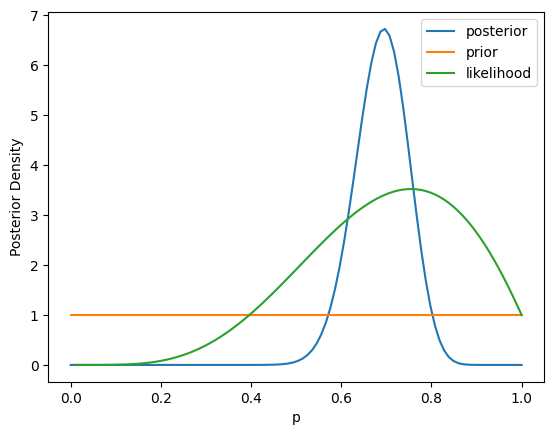

In [176]:
def make_posterior_plot(model, p_space, fname, 
                        fpath="../../data/05_reporting/problem_set_1/"):

    fpath = os.path.join(fpath, fname)

    def _plot_posterior(p_space, y, ax):
        ax.plot(p_space, y)
        ax.set_xlabel(r'p')
        ax.set_ylabel('Posterior Density')

    fig, ax = plt.subplots()

    posterior = model.posterior().pdf(p_space)
    prior = model.prior().pdf(p_space)
    likelihood = [np.sum(model.likelihood(p)) for p in p_space]

    plot_objects = [posterior, prior, likelihood]
    
    for obj in plot_objects:
        _plot_posterior(p_space, obj, ax)

    plt.legend(['posterior', 'prior', 'likelihood'])
    plt.savefig(fpath)

make_posterior_plot(model, p_space, "bnb_posterior_density.pdf")

## 5.3

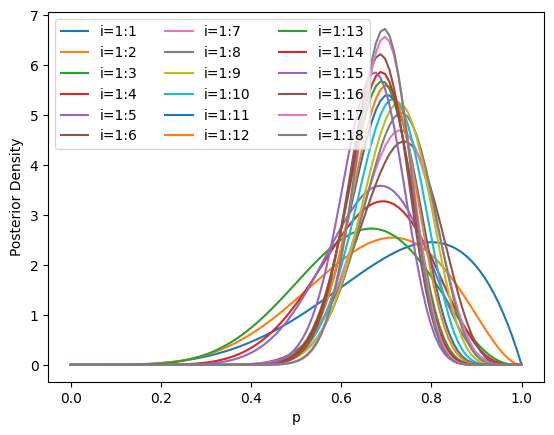

In [177]:
def plot_iterative_posterior(X, p_space, a=1, b=1):

    i_vec = []
    summaries = {}
    for i in range(len(X)):
        i_vec.append(i)
        x = X[i_vec]
        model = mpoxModel(x, a, b)
        dist = model.posterior().pdf(p_space)
        summaries[i] = model.summaries()
        plt.plot(p_space, dist)

    plt.xlabel(r'p')
    plt.ylabel('Posterior Density')

    labels = [f'i=1:{i+1}' for i in np.arange(len(X))]
    plt.legend(labels, ncol=3)

    return summaries

s = plot_iterative_posterior(X, p_space)
plt.savefig("../../data/05_reporting/problem_set_1/bnb_iterative_posterior.pdf", bbox_inches='tight')

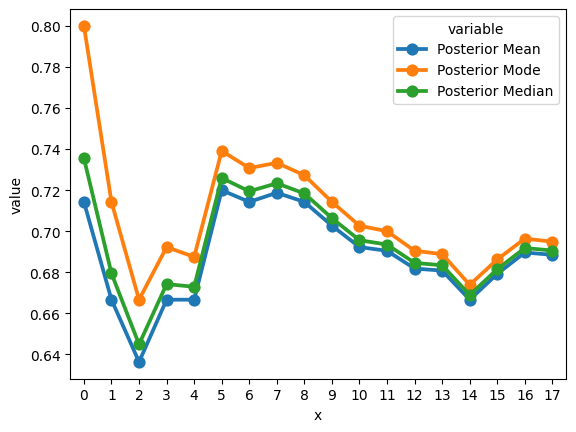

In [179]:
def plot_summaries(s: dict, fname, 
                   fpath = "../../data/05_reporting/problem_set_1") -> None:
    
    def _reshape_summaries(s: dict) -> pd.DataFrame:
        df = (pd.DataFrame(s)
            .T
            .reset_index(names='x')
            .melt(id_vars='x')
            )
        return df

    df = _reshape_summaries(s)
    sub = df[~df['variable'].str.contains('Intervals')]
    sns.pointplot(
        data=sub,
        x='x',
        y='value',
        hue='variable'
    )
    fpath = os.path.join(fpath, fname)
    plt.savefig(fpath, bbox_inches='tight')

plot_summaries(s, "iterative_posterior_summaries.pdf")

## 5.4

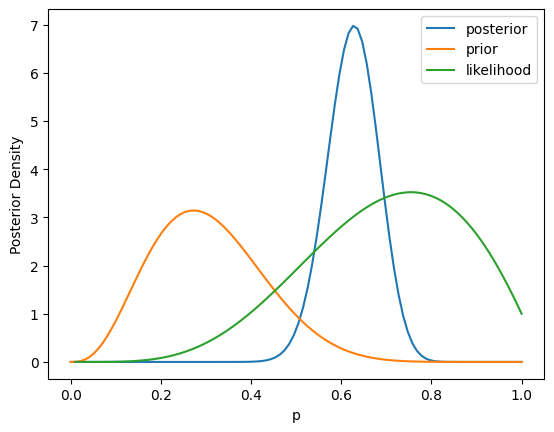

In [182]:
a = 4
b = 9

new_model = mpoxModel(X, a, b)
make_posterior_plot(new_model, p_space, fname = "new_bnb_posterior_density.pdf")


In [181]:
new_summary = new_model.summaries()
dict_to_table(new_summary, fname="new_bnb_posterior_summary.tex")